# Milestone project 1: Food Vision big

## check GPU

### In order to use mixed precision training we need to acess tesla T4 GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c1e2a144-5743-306d-5038-f4cd82c2e5b7)


## get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-07-04 04:03:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-04 04:03:23 (96.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import plot_loss_curves,pred_and_plot,unzip_data,walk_through_dir,create_tensorboard_callback,compare_historys

## use tensorflow datasets to download the data


In [ ]:
# get tensorflow datasets
import tensorflow_datasets as tfds

In [ ]:
#get all available datasets 
datasets_list=tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# load int the data
(train_data,test_data),ds_info=tfds.load(name="food101",
                                         split=["train","validation"],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete1L73YC/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete1L73YC/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# features of food101 from tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names=ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
#take one  sample of the train datasets
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
#output info about our training sample
for image,label in train_one_sample:
  print(f"""
  Image shape : {image.shape}
  Image Datatype : {image.dtype}
  Target class from food101 : {label}
  Class name (str form): {class_names[label.numpy()]}
  """)
 


  Image shape : (512, 512, 3)
  Image Datatype : <dtype: 'uint8'>
  Target class from food101 : 16
  Class name (str form): cheesecake
  


In [ ]:
#what does ou image tensor from tfds food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [ ]:
import tensorflow as tf
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### plot an image from tensorflow datasets

(-0.5, 511.5, 511.5, -0.5)

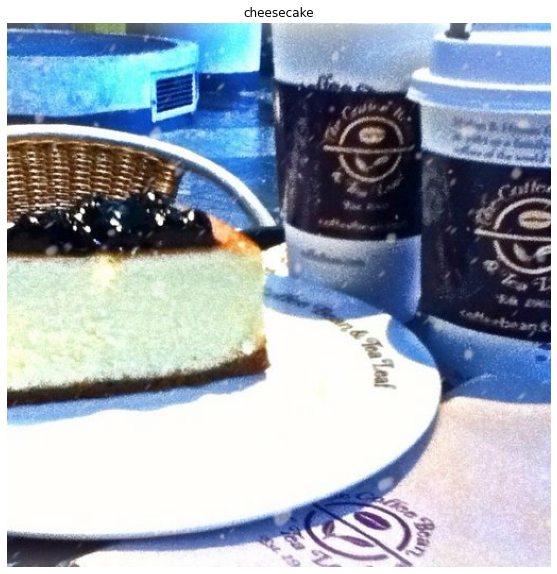

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,10])
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## create preprocessing functions for our data

In [ ]:
#make a function for preprocessing images
def preprocess_img(image,label,img_shape=224):
  """
  converts image datatype from uint8 ->float32 and reshapes 
  image to [img_shape,image_shape,colour_channels]
  """
  image=tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label # this returns tuple of (float32_image,label)


In [ ]:
preprocessed_img=preprocess_img(image,label)[0]
print(f"image before preprocessing:\n {image[:2]}...., \nshape:{image.shape},\nDatatype:{image.dtype}\n")
print(f"image after preprocessing:\n {preprocessed_img[:2]}...., \nshape:{preprocessed_img.shape},\nDatatype:{preprocessed_img.dtype}\n")

image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]...., 
shape:(512, 512, 3),
Datatype:<dtype: 'uint8'>

image after preprocessing:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...., 
shape:(224, 224, 3),
Datatype:<dtype: 'float32'>



## Batch and prepare datasets

In [ ]:
#map preprocessing function to training data
train_data =train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
#shuffle train_data and turn that into batches and prefetch it
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

#map preprocessing dunction to test data
test_data =test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## create modelling callbacks

In [ ]:
#create tensorboard callback(already created in helper functions)
from helper_functions import create_tensorboard_callback

#create model checkpoint callback to save feature extraction model
checkpoint_path="model_checkpoint/cp.ckpt"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor="val_acc",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=0)

## set up mixed precisiong training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#create base mdoel
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=(224,224,3),name="input_layer")

x=base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(len(class_names))(x)
outputs=layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
model=tf.keras.Model(inputs,outputs)

#compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
#checking layer dtype policies
for layer in model.layers:
  print(layer.dtype,layer.dtype_policy)

float32 <Policy "float32">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "float32">


In [ ]:
for layer in model.layers[1].layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy) 

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

## fit the feature extratcion model

In [ ]:
# fit the model

history_101_food_classes_fx=model.fit(train_data,epochs=3,steps_per_epoch=len(train_data),
                                      validation_data=test_data,validation_steps=int(0.15 * len(test_data)),
                          callbacks=[create_tensorboard_callback(dir_name="training_logs",experiment_name="efficientnetB0_101_classes_feature_extratc"),
                               model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetB0_101_classes_feature_extratc/20220704-041404
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8209 - accuracy: 0.5591WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 196s 75ms/step - loss: 1.8209 - accuracy: 0.5591 - val_loss: 1.2265 - val_accuracy: 0.6822
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2937 - accuracy: 0.6662WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 172s 72ms/step - loss: 1.2936 - accuracy: 0.6662 - val_loss: 1.1157 - val_accuracy: 0.7058
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1443 - accuracy: 0.7021WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 171s 71ms/step - loss: 1.1443 - accuracy: 0.7021 - val_loss: 1.0881 - val_accuracy: 0.7092


In [ ]:
# evaluate the model
results_fx=model.evaluate(test_data)
results_fx

790/790 [==============================] - 51s 64ms/step - loss: 1.0832 - accuracy: 0.7097


[1.0832322835922241, 0.709742546081543]

## Save our feature extratcion model


In [ ]:
model.save("drive/MYDRIVE/ML models/food_vision_feature_extraxtion_model")

INFO:tensorflow:Assets written to: drive/MYDRIVE/ML models/food_vision_feature_extraxtion_model/assets


INFO:tensorflow:Assets written to: drive/MYDRIVE/ML models/food_vision_feature_extraxtion_model/assets


In [ ]:
loaded_model=tf.keras.models.load_model("drive/MYDRIVE/ML models/food_vision_feature_extraxtion_model")

In [ ]:
loaded_feature_extract_model_results=loaded_model.evaluate(test_data)
loaded_feature_extract_model_results

790/790 [==============================] - 50s 64ms/step - loss: 1.0832 - accuracy: 0.7097


[1.0832313299179077, 0.709742546081543]

In [ ]:
results_fx

[1.0832322835922241, 0.709742546081543]

## fine tuning

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 
unzip_data("07_efficientnetb0_feature_extract_model_mixed_precision.zip")

--2022-07-04 04:43:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  28.2MB/s    in 0.6s    

2022-07-04 04:43:06 (28.2 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# load in saved model
model=tf.keras.models.load_model("07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
#summary of downloaded model.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
pre_trained_model_results=model.evaluate(test_data)
pre_trained_model_results

790/790 [==============================] - 54s 64ms/step - loss: 1.0881 - accuracy: 0.7065


[1.0881284475326538, 0.7064950466156006]

In [ ]:
for layer in model.layers:
  layer.trainable=True;
  print(layer.trainable)

True
True
True
True
True


In [ ]:
for layer in model.layers[1].layers:
  print(layer.name,layer.trainable,layer.dtype_policy)

input_1 True <Policy "float32">
rescaling True <Policy "mixed_float16">
normalization True <Policy "float32">
stem_conv_pad True <Policy "mixed_float16">
stem_conv True <Policy "mixed_float16">
stem_bn True <Policy "mixed_float16">
stem_activation True <Policy "mixed_float16">
block1a_dwconv True <Policy "mixed_float16">
block1a_bn True <Policy "mixed_float16">
block1a_activation True <Policy "mixed_float16">
block1a_se_squeeze True <Policy "mixed_float16">
block1a_se_reshape True <Policy "mixed_float16">
block1a_se_reduce True <Policy "mixed_float16">
block1a_se_expand True <Policy "mixed_float16">
block1a_se_excite True <Policy "mixed_float16">
block1a_project_conv True <Policy "mixed_float16">
block1a_project_bn True <Policy "mixed_float16">
block2a_expand_conv True <Policy "mixed_float16">
block2a_expand_bn True <Policy "mixed_float16">
block2a_expand_activation True <Policy "mixed_float16">
block2a_dwconv_pad True <Policy "mixed_float16">
block2a_dwconv True <Policy "mixed_float16

## setup the early stopping callback function

In [ ]:
#early stopping
early_stop_callback=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)

#model checkpoint 
checkpoint_path="model_checkpoint/cp.ckpt"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor="val_loss",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=0)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
history_fine_tune_food_vision=model.fit(train_data,epochs=100,steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(0.15 * len(test_data)),
                                        initial_epoch=history_101_food_classes_fx.epoch[2],
                                        callbacks=[create_tensorboard_callback(dir_name="train_logs",experiment_name="efficientnetB0_101_classes_fine_Tuning"),
                                                   model_checkpoint,
                                                   early_stop_callback])


Saving TensorBoard log files to: train_logs/efficientnetB0_101_classes_fine_Tuning/20220704-051241
Epoch 3/100
2368/2368 [==============================] - 363s 146ms/step - loss: 0.9227 - accuracy: 0.7523 - val_loss: 0.8068 - val_accuracy: 0.7762
Epoch 4/100
2368/2368 [==============================] - 346s 145ms/step - loss: 0.5778 - accuracy: 0.8389 - val_loss: 0.7881 - val_accuracy: 0.7889
Epoch 5/100
2368/2368 [==============================] - 341s 143ms/step - loss: 0.3325 - accuracy: 0.9053 - val_loss: 0.8458 - val_accuracy: 0.7860
Epoch 6/100
2368/2368 [==============================] - 342s 144ms/step - loss: 0.1744 - accuracy: 0.9483 - val_loss: 0.9645 - val_accuracy: 0.7865
Epoch 7/100
2368/2368 [==============================] - 343s 144ms/step - loss: 0.1067 - accuracy: 0.9667 - val_loss: 1.0407 - val_accuracy: 0.7860


In [ ]:
fine_tune_results=model.evaluate(test_data)

790/790 [==============================] - 61s 77ms/step - loss: 1.0562 - accuracy: 0.7790


In [ ]:
fine_tune_results

[1.056227684020996, 0.7789703011512756]

In [ ]:
model.save("drive/MYDRIVE/ML models/food_vision_fine_tuning_mixed_precision_model")

INFO:tensorflow:Assets written to: drive/MYDRIVE/ML models/food_vision_fine_tuning_mixed_precision_model/assets


INFO:tensorflow:Assets written to: drive/MYDRIVE/ML models/food_vision_fine_tuning_mixed_precision_model/assets


In [ ]:
model.save("ML models/food_vision_fine_tuning_mixed_precision_model.h5")